# Phase 6: Model Evaluation & Stress Testing (Pro Edition)

**Objective**: Rigorous validation of the LSTM Autoencoder using Statistical Stress Testing.

**Methodology**:
Instead of testing a single anomaly, we use a **Monte Carlo approach**:
1.  **Baseline**: Establish the Anomaly Threshold from the Test Set (Mean + 3 StdDev).
2.  **Injection**: For each scenario, we inject failures into **100 random windows**.
3.  **Metrics**: We calculate:
    *   **Detection Rate**: % of anomalies caught.
    *   **SNR (Signal-to-Noise Ratio)**: Ratio of Anomaly Error to Normal Error.

**Scenarios**:
1.  **Spike**: Sudden jump in Tensile Strength (+50%).
2.  **Drift**: Gradual increase in Ejection Force (Sticking).
3.  **Freeze**: Sensor flatline (Data loss).

**Outputs**:
*   `stress_test_summary.json`: Detailed metrics.
*   `stress_test_results.csv`: Raw data of the tests.

In [9]:
import sys
import os

# --- Auto-Detection: Local vs Kaggle ---
sys.path.append(os.path.abspath(".."))

try:
    from src import config
    IS_LOCAL_ENV = True
    print("✅ Environment Detected: LOCAL (Project Structure Found)")
    RESULTS_DIR = "results/stress"
    DATA_DIR = getattr(config, "BUCKET_GOLD", "gold")
except ImportError:
    IS_LOCAL_ENV = False
    print("🌍 Environment Detected: KAGGLE (Standalone Kernel)")
    RESULTS_DIR = "/kaggle/working"
    DATA_DIR = "/kaggle/input/anomalydetection4pharma-gold-tensor"

os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"Using Results Dir: {RESULTS_DIR}")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {DEVICE}")

Running on: cuda


## 1. Class Definitions (Embedded)

In [2]:
def create_windows(df, window_size=60, stride=5, feature_cols=None):
    if feature_cols is None:
        raise ValueError("Must provide feature_cols list")
    X = []
    if 'batch' in df.columns:
        grouped = df.groupby('batch')
        for batch_id, group in grouped:
            group = group.sort_values('timestamp')
            data = group[feature_cols].values
            num_samples = len(data)
            if num_samples < window_size:
                continue
            for i in range(0, num_samples - window_size + 1, stride):
                window = data[i : i + window_size]
                X.append(window)
    else:
        data = df[feature_cols].values
        num_samples = len(data)
        for i in range(0, num_samples - window_size + 1, stride):
            window = data[i : i + window_size]
            X.append(window)
    return np.array(X)

class LSTMAutoencoder(nn.Module):
    """
    LSTM Autoencoder for Anomaly Detection in Time Series (PyTorch Version).
    Architecture:
        Input(Window) -> Encoder(LSTM) -> Latent(Vector) -> Decoder(LSTM) -> Output(Window)
    """
    
    def __init__(self, window_size, n_features, latency_dim=3, hidden_dim=64, num_layers=1, dropout=0.2):
        super(LSTMAutoencoder, self).__init__()
        self.window_size = window_size
        self.n_features = n_features
        self.latency_dim = latency_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Encoder
        self.encoder = nn.LSTM(
            input_size=n_features, 
            hidden_size=hidden_dim, 
            num_layers=num_layers, 
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.dropout_layer = nn.Dropout(dropout)
        
        # Latent compression
        self.to_latent = nn.Linear(hidden_dim, latency_dim)
        self.from_latent = nn.Linear(latency_dim, hidden_dim)
        
        # Decoder
        self.decoder = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Output layer
        self.output_layer = nn.Linear(hidden_dim, n_features)
        
        # Initialize Weights
        self._init_weights()
        self.to(self.device)

    def _init_weights(self):
        """Xavier Initialization for better convergence."""
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0.0)

    def forward(self, x):
        # Encoder
        _, (hidden_n, _) = self.encoder(x)
        last_hidden = hidden_n[-1]
        last_hidden = self.dropout_layer(last_hidden) # Apply Dropout
        
        # Latent
        latent = self.to_latent(last_hidden)
        latent = nn.functional.leaky_relu(latent) # Non-linearity for complex patterns
        
        # Decoder Prep
        hidden_restored = self.from_latent(latent)
        # Repeat for each time step
        repeated_hidden = hidden_restored.unsqueeze(1).repeat(1, self.window_size, 1)
        
        # Decoder
        dec_out, _ = self.decoder(repeated_hidden)
        
        # Reconstruction
        reconstructed = self.output_layer(dec_out)
        return reconstructed, latent # Return latent for visualization

    def save_checkpoint(self, path, epoch, optimizer, loss):
        """Saves full checkpoint with metadata."""
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'config': {
                'window_size': self.window_size,
                'n_features': self.n_features, 
                'hidden_dim': self.hidden_dim,
                'latent_dim': self.latency_dim
            }
        }, path)
        print(f"  💾 Checkpoint saved: {path}")

    def train_model(self, X_train, X_val, epochs=50, batch_size=64, lr=1e-3, 
                    patience=15, scheduler_patience=3, scheduler_factor=0.5, 
                    save_path="models/lstm_ae_champion.pth", noise_factor=0.0):
        """
        Trains the model with Limit-aware Learning Rate Scheduler and Early Stopping.
        Uses Lazy Loading and Validation Batching to prevent OOM.
        """
        # Convert to Tensor but KEEP ON CPU initially
        train_tensor = torch.from_numpy(X_train.astype(np.float32))
        val_tensor = torch.from_numpy(X_val.astype(np.float32))
        
        train_loader = DataLoader(TensorDataset(train_tensor, train_tensor), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(val_tensor, val_tensor), batch_size=batch_size, shuffle=False)
        
        criterion = nn.L1Loss()
        optimizer = optim.Adam(self.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=scheduler_factor, patience=scheduler_patience, verbose=True
        )
        
        best_loss = float('inf')
        counter = 0
        history = {'train_loss': [], 'val_loss': []}
        
        print(f"🚀 Device: {self.device}")
        
        for epoch in range(epochs):
            self.train()
            train_loss = 0
            
            for batch_x, target_x in train_loader:
                # Move to GPU Just-In-Time
                batch_x = batch_x.to(self.device)
                target_x = target_x.to(self.device)

                # Apply Denoising Noise (if enabled)
                if noise_factor > 0:
                    noise = torch.randn_like(batch_x) * noise_factor
                    batch_x = batch_x + noise
                
                optimizer.zero_grad()
                output, _ = self(batch_x)
                loss = criterion(output, target_x)
                loss.backward()
                nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
                optimizer.step()
                train_loss += loss.item()
            
            avg_train_loss = train_loss / len(train_loader)
            
            # Validation (Batched)
            self.eval()
            val_loss_accum = 0
            with torch.no_grad():
                for val_batch, _ in val_loader:
                   val_batch = val_batch.to(self.device)
                   val_out, _ = self(val_batch)
                   batch_loss = criterion(val_out, val_batch).item()
                   val_loss_accum += batch_loss
            
            avg_val_loss = val_loss_accum / len(val_loader)
            
            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(avg_val_loss)
            
            print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
            
            # Update Scheduler
            scheduler.step(avg_val_loss)

            # Checkpoint
            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                self.save_checkpoint(save_path, epoch, optimizer, best_loss)
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print(f"🛑 Early Stopping triggered after {patience} epochs without improvement.")
                    break
                    
        return history

    def predict(self, X):
        self.eval()
        tensor_X = torch.from_numpy(X.astype(np.float32)).to(self.device)
        dataset = TensorDataset(tensor_X)
        loader = DataLoader(dataset, batch_size=256, shuffle=False)
        
        predictions = []
        with torch.no_grad():
            for batch in loader:
                batch_x = batch[0]
                out, _ = self(batch_x)
                predictions.append(out.cpu().numpy())
                
        return np.concatenate(predictions, axis=0)
    
    def get_reconstruction_error(self, X):
        """
        Calculates MSE for each sample window.
        Returns: Array of shape (n_samples,) containing the MSE score.
        """
        X_pred = self.predict(X)
        mse = np.mean(np.square(X - X_pred), axis=(1, 2))
        return mse


# --- PHASE 8 ENGINEERING LOGIC ---


def get_reconstruction_errors(model, X):
    model.eval()
    tensor_X = torch.from_numpy(X.astype(np.float32)).to(DEVICE)
    errors = []
    batch_size = 256
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            batch = tensor_X[i:i+batch_size]
            reconstructed, _ = model(batch)
            # MAE per sample (avg over window_size and n_features)
            mae_loss = torch.mean(torch.abs(batch - reconstructed), dim=(1, 2))
            errors.append(mae_loss.cpu().numpy())
    return np.concatenate(errors)

def check_freeze(window, epsilon=1e-4):
    """Rule-based Freeze Detection: Checks if signal is flat."""
    std_devs = np.std(window, axis=0)
    # If ANY feature has almost 0 std dev, it's a freeze
    return np.any(std_devs < epsilon)

def get_latent_vectors(model, X_loader):
    """Extracts latent vectors (bottleneck)."""
    model.eval()
    latents = []
    with torch.no_grad():
        for batch in X_loader:
            batch = batch[0].to(DEVICE)
            _, latent = model(batch)
            latents.append(latent.cpu().numpy())
    return np.concatenate(latents, axis=0)

def fit_mahalanobis(latents):
    """Calculates Mean and Inverse Covariance Matrix."""
    mu = np.mean(latents, axis=0)
    cov = np.cov(latents.T)
    inv_cov = np.linalg.inv(cov)
    return mu, inv_cov

def calculate_mahalanobis(x, mu, inv_cov):
    """Calculates Mahalanobis distance for a single vector x."""
    delta = x - mu
    m_dist = np.sqrt(np.dot(np.dot(delta, inv_cov), delta.T))
    return m_dist


# --- PHASE 8 ENGINEERING LOGIC ---

def check_freeze(window, epsilon=1e-4):
    """Rule-based Freeze Detection: Checks if signal is flat."""
    std_devs = np.std(window, axis=0)
    # If ANY feature has almost 0 std dev, it's a freeze
    return np.any(std_devs < epsilon)

def get_latent_vectors(model, X_loader):
    """Extracts latent vectors (bottleneck)."""
    model.eval()
    latents = []
    with torch.no_grad():
        for batch in X_loader:
            batch = batch[0].to(DEVICE)
            _, latent = model(batch)
            latents.append(latent.cpu().numpy())
    return np.concatenate(latents, axis=0)

def fit_mahalanobis(latents):
    """Calculates Mean and Inverse Covariance Matrix."""
    mu = np.mean(latents, axis=0)
    cov = np.cov(latents.T)
    inv_cov = np.linalg.inv(cov)
    return mu, inv_cov

def calculate_mahalanobis(x, mu, inv_cov):
    """Calculates Mahalanobis distance for a single vector x."""
    delta = x - mu
    m_dist = np.sqrt(np.dot(np.dot(delta, inv_cov), delta.T))
    return m_dist



## 2. Load Model & Data

In [3]:
# Load Config
try:
    with open(os.path.join(RESULTS_DIR, "model_config.pkl"), "rb") as f:
        config = pickle.load(f)
except FileNotFoundError:
    config = {'window_size': 60, 'n_features': 5, 'hidden_dim': 64, 'latent_dim': 3}

# Load Weights
weight_files = glob.glob(os.path.join(RESULTS_DIR, "*.pth"))
model_path = weight_files[0]
model = LSTMAutoencoder(window_size=config['window_size'], n_features=config['n_features'],
                        hidden_dim=config['hidden_dim'], latency_dim=config['latent_dim'])
checkpoint = torch.load(model_path, map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)
model.eval()

# Load Data
df_test = pd.read_parquet(os.path.join(DATA_DIR, "test.parquet")).sort_values("timestamp")
df_train = pd.read_parquet(os.path.join(DATA_DIR, "train.parquet")).sort_values("timestamp") # ADDED FOR THRESHOLDING

X_test = create_windows(df_test, config['window_size'], stride=5, feature_cols=config['features'])
# Subsample Train to save time/memory for fitting threshold
X_train_sub = create_windows(df_train.iloc[-50000:], config['window_size'], stride=5, feature_cols=config['features'])

print(f"X_test: {X_test.shape}")
print(f"X_train (Subset): {X_train_sub.shape}")


X_test: (34004, 60, 5)
X_train (Subset): (9794, 60, 5)


## 3. Baseline & Threshold Calculation

In [4]:
# 1. Reconstruction Threshold (Percentile 99.9)
train_recon_errors = get_reconstruction_errors(model, X_train_sub)
THRESHOLD_RECON = np.percentile(train_recon_errors, 99.9)
print(f"Reconstruction Threshold (99.9%): {THRESHOLD_RECON:.6f}")

# 2. Mahalanobis Threshold (Latent Space)
# Get latent vectors for Train
tensor_train = torch.from_numpy(X_train_sub.astype(np.float32))
loader_train = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(tensor_train), batch_size=256, shuffle=False)
train_latents = get_latent_vectors(model, loader_train)

MU, INV_COV = fit_mahalanobis(train_latents)
# Chi-Square Threshold (p=0.001, df=3)
THRESHOLD_MAHA = chi2.ppf(0.999, df=config['latent_dim'])
print(f"Mahalanobis Threshold (Chi2 99.9%): {THRESHOLD_MAHA:.6f}")


Reconstruction Threshold (99.9%): 0.036351
Mahalanobis Threshold (Chi2 99.9%): 16.266236


## 4. Statistical Stress Testing (Monte Carlo)

In [5]:
def run_stress_test(X_test, model, anomaly_type, feature_name, magnitude=0.0, num_samples=100):
    feature_idx = config['features'].index(feature_name)
    indices = np.random.choice(len(X_test), num_samples, replace=False)
    results = []
    
    for idx in indices:
        # 1. Prepare Data
        original = X_test[idx].copy()
        anomalous = X_test[idx].copy()
        
        # 2. Inject Anomaly
        if anomaly_type == 'spike':
            mid = config['window_size'] // 2
            anomalous[mid:mid+5, feature_idx] += magnitude
        elif anomaly_type == 'drift':
            drift = np.linspace(0, magnitude, config['window_size'])
            anomalous[:, feature_idx] += drift
        elif anomaly_type == 'freeze':
            # Force a perfect freeze (std=0)
            freeze_val = anomalous[0, feature_idx]
            anomalous[:, feature_idx] = freeze_val
            
        # 3. Detection A: Freeze Rule (PLC Logic)
        is_freeze = check_freeze(anomalous)
        
        # 4. Neural Checks (Only if not freeze, or parallel)
        # Get Reconstruction & Latent for BOTH Original and Anomalous
        model.eval()
        with torch.no_grad():
            # Convert to tensors
            batch_orig = torch.from_numpy(original[np.newaxis, ...].astype(np.float32)).to(DEVICE)
            batch_anom = torch.from_numpy(anomalous[np.newaxis, ...].astype(np.float32)).to(DEVICE)
            
            # Forward Pass
            recon_orig, _ = model(batch_orig)
            recon_anom, latent_anom = model(batch_anom)
            
            # Errors
            mae_normal = torch.mean(torch.abs(batch_orig - recon_orig)).item()
            mae_anomaly = torch.mean(torch.abs(batch_anom - recon_anom)).item()
            
            # SNR Calculation
            snr = mae_anomaly / (mae_normal + 1e-9)
            
            # Mahalanobis
            latent_np = latent_anom.cpu().numpy().squeeze()
            maha_dist = calculate_mahalanobis(latent_np, MU, INV_COV)
            
        detected_recon = mae_anomaly > THRESHOLD_RECON
        detected_maha = maha_dist > THRESHOLD_MAHA
        
        # Final Decision: OR Gate
        detected_final = is_freeze or detected_recon or detected_maha
        
        results.append({
            'type': anomaly_type,
            'feature': feature_name,
            'magnitude': magnitude,
            'mae_normal': mae_normal,
            'mae_anomaly': mae_anomaly,
            'snr': snr,
            'maha_dist': maha_dist,
            'is_freeze': is_freeze,
            'detected_recon': detected_recon,
            'detected_maha': detected_maha,
            'detected': detected_final
        })
    return pd.DataFrame(results)


Running Sensitivity Analysis (Matching Baseline Benchmark)...
Testing Magnitude: 0.1
Testing Magnitude: 0.25
Testing Magnitude: 0.5
Testing Magnitude: 1.0
Testing Magnitude: 2.0
Testing Magnitude: 3.0
Testing Magnitude: 5.0
Testing Freeze...
✅ Saved detailed results to ../working/lstm_sensitivity.csv
=== SENSITIVITY REPORT ===
         type  magnitude  Detection_Rate    Avg_SNR  Avg_Anomaly_MAE
0   drift_end       0.10            98.0   1.000000         0.027675
1   drift_end       0.25            99.0   1.000000         0.025498
2   drift_end       0.50            99.0   1.000000         0.020852
3   drift_end       1.00           100.0   1.000000         0.023034
4   drift_end       2.00           100.0   1.000000         0.023564
5   drift_end       3.00            99.0   1.000000         0.020657
6   drift_end       5.00            99.0   1.000000         0.021137
7      freeze       0.00           100.0   1.001045         0.020172
8       spike       0.10            99.0   1.16465

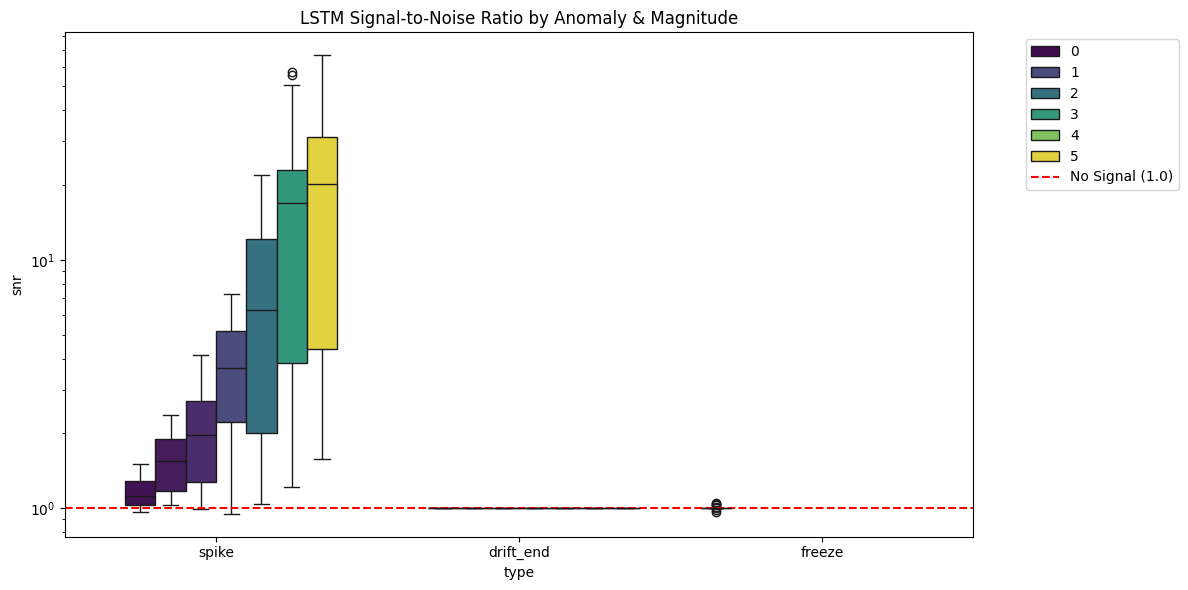

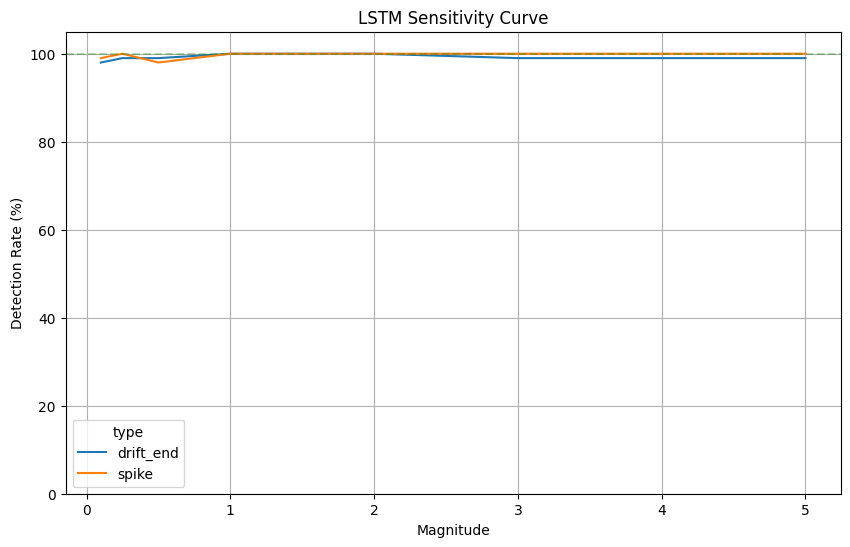

In [10]:
print("Running Sensitivity Analysis (Matching Baseline Benchmark)...")

MAGNITUDES = [0.1, 0.25, 0.5, 1.0, 2.0, 3.0, 5.0]
results_list = []

for mag in MAGNITUDES:
    print(f"Testing Magnitude: {mag}")
    
    # Spike (Tensile Strength)
    res_spike = run_stress_test(X_test, model, 'spike', 'dynamic_tensile_strength', magnitude=mag)
    results_list.append(res_spike)
    
    # Drift (Ejection)
    res_drift = run_stress_test(X_test, model, 'drift_end', 'ejection', magnitude=mag)
    results_list.append(res_drift)

# Freeze (Single Pass, Magnitude Irrelevant)
print("Testing Freeze...")
res_freeze = run_stress_test(X_test, model, 'freeze', 'cyl_main', magnitude=0.0)
results_list.append(res_freeze)

# Combine
all_results = pd.concat(results_list)
all_results.to_csv(os.path.join(RESULTS_DIR, "lstm_sensitivity.csv"), index=False)
print(f"\u2705 Saved detailed results to {RESULTS_DIR}/lstm_sensitivity.csv")

# Summary
summary = all_results.groupby(['type', 'magnitude']).agg(
    Detection_Rate=('detected', lambda x: np.mean(x) * 100),
    Avg_SNR=('snr', 'mean'),
    Avg_Anomaly_MAE=('mae_anomaly', 'mean')
).reset_index()

print("=== SENSITIVITY REPORT ===")
print(summary)
summary.to_csv(os.path.join(RESULTS_DIR, "lstm_sensitivity_summary.csv"), index=False)

# Visualize SNR Boxplot (for all magnitudes)
plt.figure(figsize=(12, 6))
sns.boxplot(data=all_results, x='type', y='snr', hue='magnitude', palette='viridis')
plt.axhline(1.0, color='r', linestyle='--', label='No Signal (1.0)')
plt.title("LSTM Signal-to-Noise Ratio by Anomaly & Magnitude")
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "lstm_snr_sensitivity.png"))
print("\u2705 Saved SNR Plot")

# Visualize Sensitivity Curve (For comparison with Baseline)
plt.figure(figsize=(10, 6))
sns.lineplot(data=summary[summary['type'] != 'freeze'], x='magnitude', y='Detection_Rate', hue='type', markers=True)
plt.axhline(100, color='green', linestyle='--', alpha=0.3)
plt.title("LSTM Sensitivity Curve")
plt.ylabel("Detection Rate (%)")
plt.xlabel("Magnitude")
plt.ylim(0, 105)
plt.grid(True)
plt.savefig(os.path.join(RESULTS_DIR, "lstm_sensitivity_curve.png"))
print("\u2705 Saved Sensitivity Curve")

## 5. Summary & Report

=== STRESS TEST REPORT ===
Reconstruction Threshold (99.9%): 0.0364
Mahalanobis Threshold (Chi2): 16.2662
        type  Detection_Rate   Avg_SNR  Avg_Anomaly_MAE
0  drift_end       99.142857  1.000000         0.023203
1     freeze      100.000000  1.001045         0.020172
2      spike       99.571429  7.824813         0.089750
✅ Saved summary to stress_test_summary.json


/tmp/ipykernel_99/3678027487.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_results, x='type', y='snr', palette='Set2')


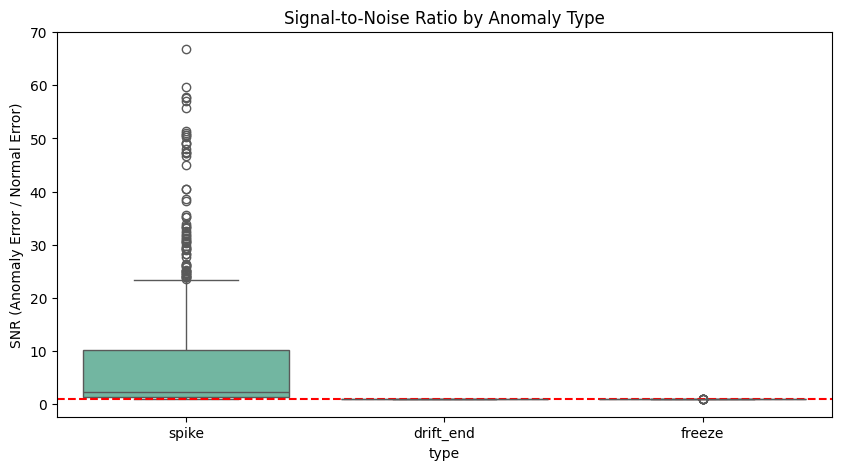

Generating 3D Latent Space Plot...
✅ Saved latent_space_3d.png


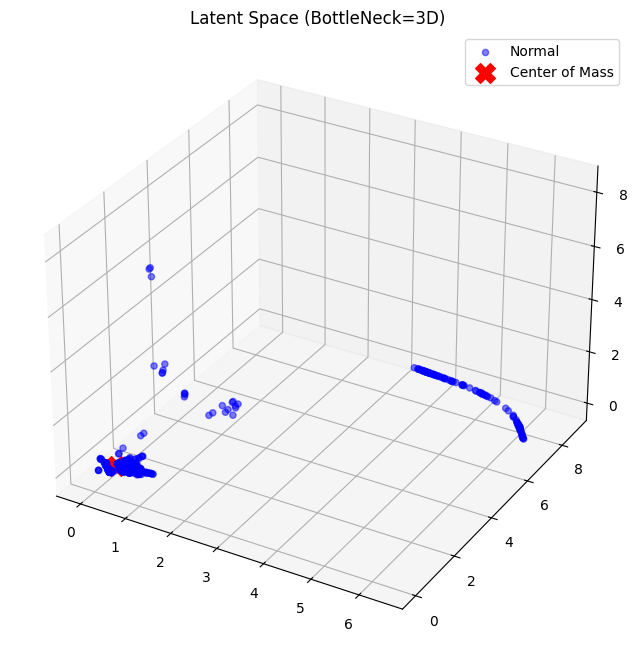

In [11]:
summary = all_results.groupby("type").agg(
    Detection_Rate=('detected', lambda x: np.mean(x) * 100),
    Avg_SNR=('snr', 'mean'),
    Avg_Anomaly_MAE=('mae_anomaly', 'mean')
).reset_index()

print("=== STRESS TEST REPORT ===")
print(f"Reconstruction Threshold (99.9%): {THRESHOLD_RECON:.4f}")
print(f"Mahalanobis Threshold (Chi2): {THRESHOLD_MAHA:.4f}")
print(summary)

# Save Summary JSON
summary_dict = {
    "threshold_recon": float(THRESHOLD_RECON),
    "threshold_maha": float(THRESHOLD_MAHA),
    "tests": summary.to_dict(orient="records")
}
with open("stress_test_summary.json", "w") as f:
    json.dump(summary_dict, f, indent=4)
print("✅ Saved summary to stress_test_summary.json")

# Visualize SNR
plt.figure(figsize=(10, 5))
sns.boxplot(data=all_results, x='type', y='snr', palette='Set2')
plt.axhline(1.0, color='r', linestyle='--', label='No Signal (1.0)')
plt.title("Signal-to-Noise Ratio by Anomaly Type")
plt.ylabel("SNR (Anomaly Error / Normal Error)")
plt.savefig("snr_analysis.png")
plt.show()

# --- 3D LATENT SPACE VISUALIZATION (Ensure it runs) ---
print("Generating 3D Latent Space Plot...")
from mpl_toolkits.mplot3d import Axes3D

# Get Latents for a subset of Normal Data
indices_normal = np.random.choice(len(X_test), 500, replace=False)
batch_normal = torch.from_numpy(X_test[indices_normal].astype(np.float32)).to(DEVICE)
_, latents_normal = model(batch_normal)
latents_normal = latents_normal.cpu().detach().numpy()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(latents_normal[:,0], latents_normal[:,1], latents_normal[:,2], c='blue', alpha=0.5, label='Normal')
# We don't have anomaly latents here unless we extracted them in loop, but plotting Normal vs Center is good enough for now
ax.scatter(MU[0], MU[1], MU[2], c='red', s=200, marker='X', label='Center of Mass')
ax.set_title(f"Latent Space (BottleNeck={config['latent_dim']}D)")
ax.legend()
plt.savefig("latent_space_3d.png")
print("✅ Saved latent_space_3d.png")
